## Fast lap analysis

First create an InfluxDB client by importing the modules and setting all the required configuration.

### Imports and configurations

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import influxdb_client
import scipy

from influxdb_client.client.write_api import SYNCHRONOUS

import warnings
from influxdb_client.client.warnings import MissingPivotFunction

warnings.simplefilter("ignore", MissingPivotFunction)

# configure influxdb client
ORG = "b4mad"
TOKEN = os.environ.get(
    "INFLUXDB_TOKEN",
    "citqAMr66LLb25hvaaZm2LezOc88k2ocOFJcJDR6QB-RmLJa_-sAr9kYB4vSFYaz8bt26lm7SokVgpQKdgKFKA==",
)
URL = "https://telemetry.b4mad.racing/"

# and create the client and a quary api
client = influxdb_client.InfluxDBClient(url=URL, token=TOKEN, org=ORG)
query_api = client.query_api()

car = "Dallara IR18"
game = "iRacing"
track = "sebring international"
sessions = {
    "1669961020": [7, 8, 9, 10, 11],
    # "1669925210": [3,4],
}
n = 0
for session, laps in sessions.items():
    n += len(laps)

# Splice a track into segments

Using the combined / averaged values of the `SteeringAngle` data, we want to splice the track `DistanceRoundTrack` into segments. 
* A segement is defined by the start and end of a major turn.
* Each segment connects directly to the next segment.
* The start of a segment is the middle betwee two turns (i.e not just at the beginning of a turn).

See below for the example of the `sebring international` track.


### Compute average Brake, Throttle, SteeringAngle, Gear, DistanceRoundTrack, SpeedMs and CurrentLapTime over the n fastest laps

In [2]:
# Construct a dictionary that will store the data
features = [
    "Brake",
    "Throttle",
    "SteeringAngle",
    "Gear",
    "DistanceRoundTrack",
    "SpeedMs",
    "CurrentLapTime",
]
feature_values = {}
for feature in features:
    feature_values[feature] = []

# Loop over the SessionIds for the n fastest laps
# for i,session in enumerate(np.unique(session_list)):
for session in sessions.keys():
    laps = sessions[session]
    for lap in laps:
        print(f"Getting data for SessionId: {session} / {lap}")
        query = f"""
        from(bucket: "racing")
        |> range(start: -10y, stop: now())
        |> filter(fn: (r) => r["_measurement"] == "laps_cc")
        |> filter(fn: (r) => r["SessionId"] == "{session}")
        // |> filter(fn: (r) => r["GameName"] == "{game}")
        // |> filter(fn: (r) => r["CarModel"] == "{car}")
        // |> filter(fn: (r) => r["TrackCode"] == "{track}")
        |> filter(fn: (r) => r["CurrentLap"] == "{lap}")
        |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
        |> sort(columns: ["_time"], desc: false)
        """
        # Open the data frame corresponding to session
        try:
            df = query_api.query_data_frame(org=ORG, query=query)
            for feature in features:
                feature_values[feature].append(df[feature].values)
            # print(query)
            # display(df)
        except:
            print(f"Could not get data for SessionId: {session}")
            continue

Getting data for SessionId: 1669961020 / 7
Getting data for SessionId: 1669961020 / 8
Getting data for SessionId: 1669961020 / 9
Getting data for SessionId: 1669961020 / 10
Getting data for SessionId: 1669961020 / 11


In [3]:
# Define the maximal size of all SteeringAngle arrays
max_number_of_datapoints = max([s.size for s in feature_values["SteeringAngle"]])

# Define a dictionnary that will store the data
# we need a dictionnary that contains arrays with all the same size,
# rather than the previous dictionnary that was containing lists
data_arrays = {}
for feature in features:
    data_arrays[feature] = np.zeros((n, max_number_of_datapoints))

# Better to have ones for Throttle instead of zeros
data_arrays["Throttle"] = np.ones((n, max_number_of_datapoints))

# Fill the dictionnary with data
for i in range(n):
    for feature in features:
        data_arrays[feature][i][: feature_values[feature][i].size] = feature_values[
            feature
        ][i]

In [4]:
# Do the average of all data in the dictionnary
# over the n fastest laps
# and store it in a new dictionnary
# FIXME: not sure if this is the best way to find the average signal

av_data_arrays = {}
for feature in features:
    av_data_arrays[feature] = np.mean(data_arrays[feature], axis=0)

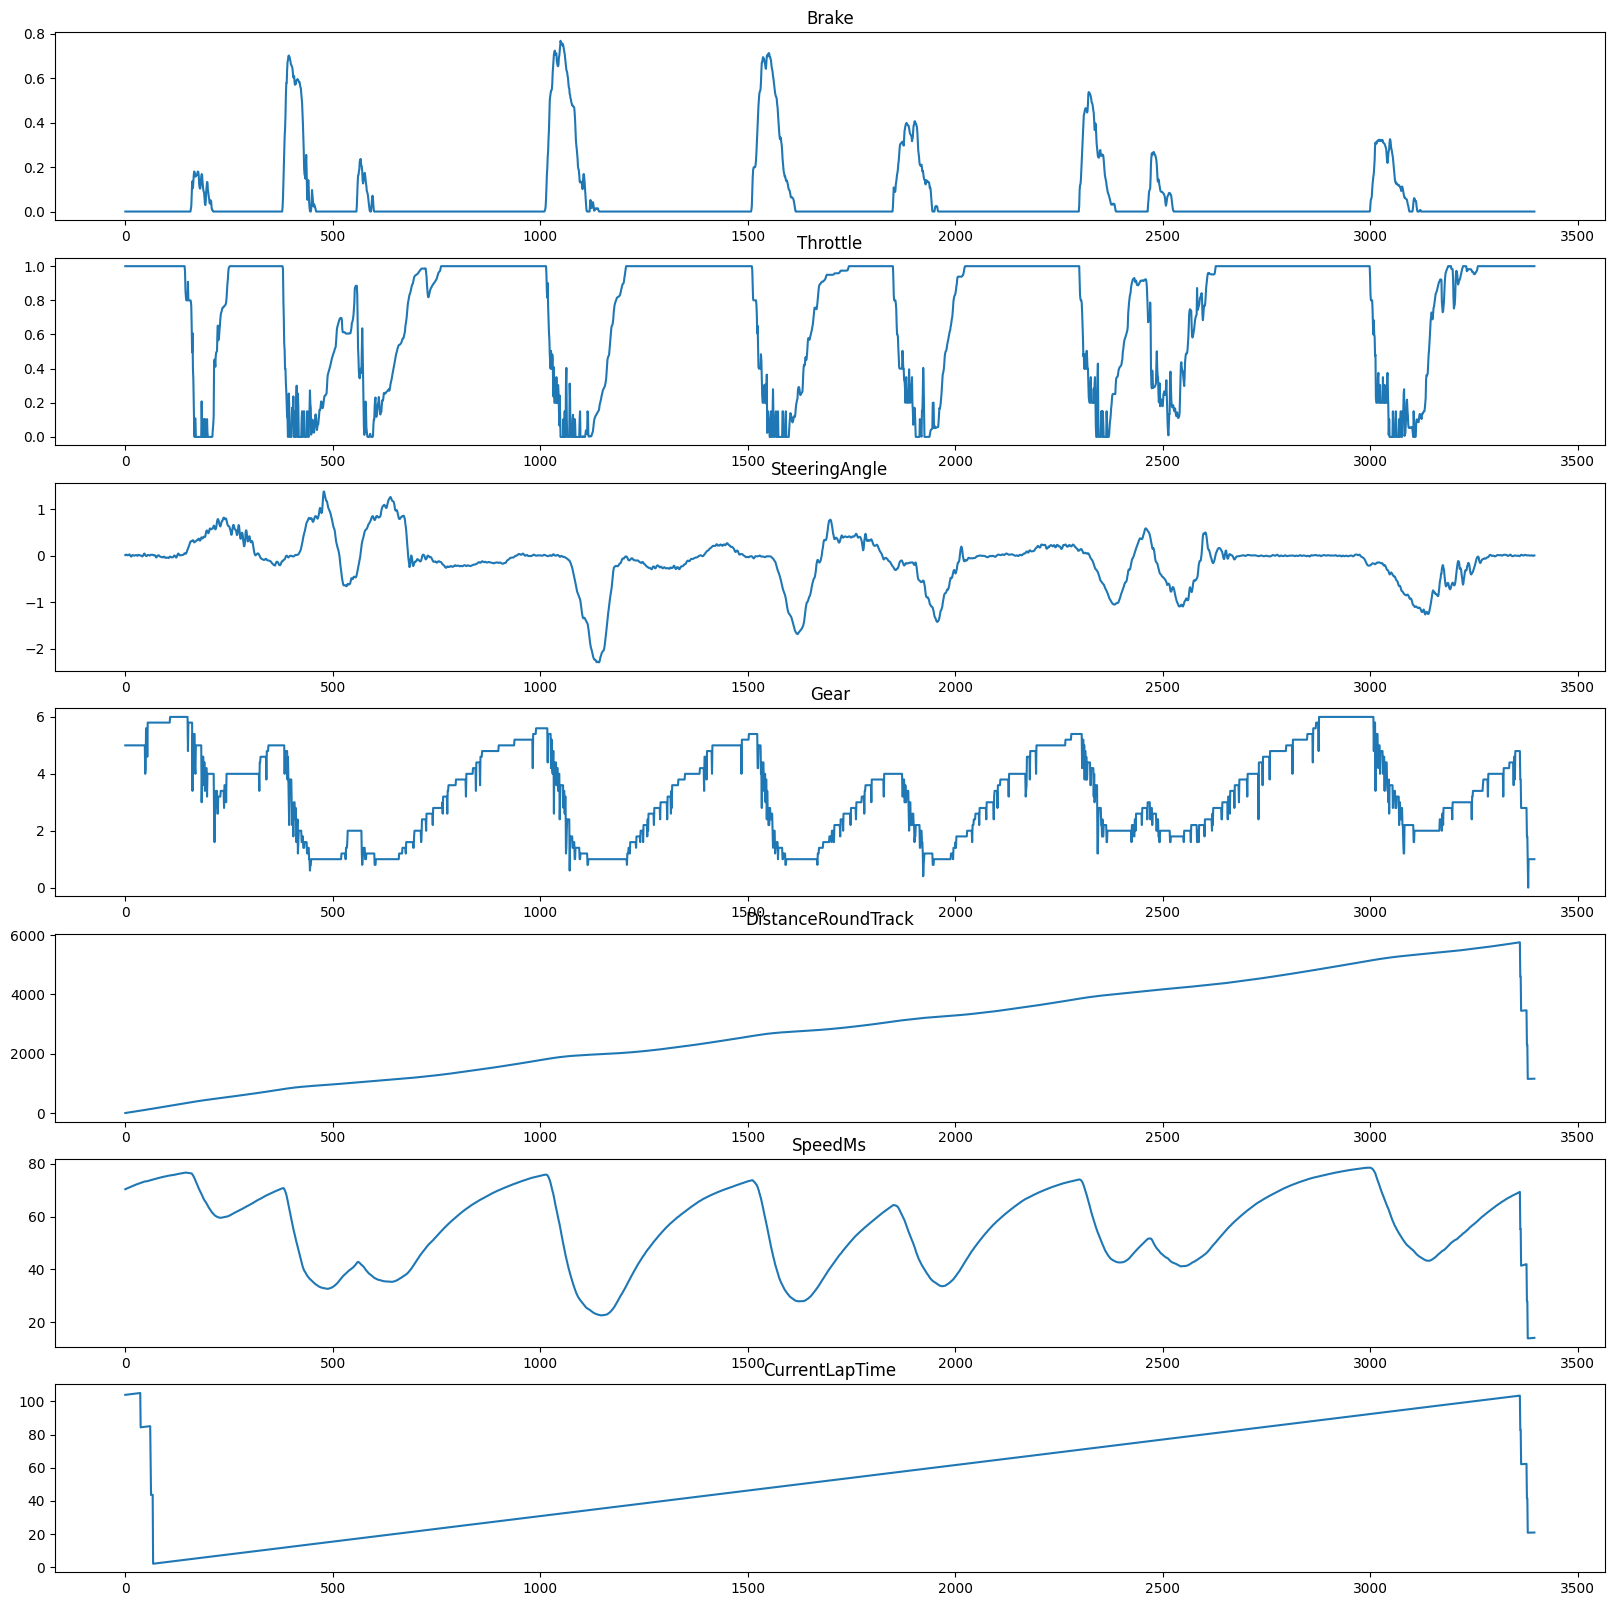

In [5]:
# Plot the averaged data
fig, ax = plt.subplots(len(features), figsize=(20, 20))
for i, feature in enumerate(features):
    ax[i].plot(av_data_arrays[feature])
    ax[i].set_title(feature)

### Slice each laps into segments

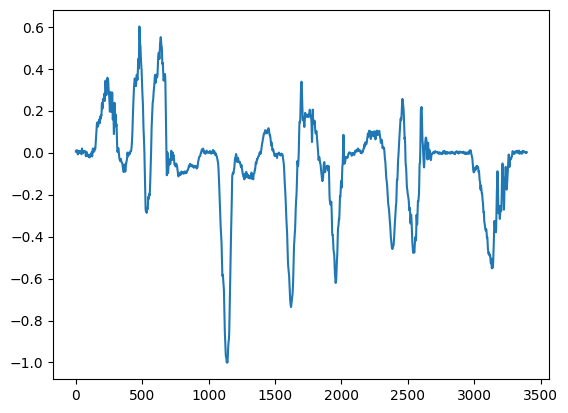

In [6]:
# for readibility, define a variable that store the average SteeringAngle array
steer = av_data_arrays["SteeringAngle"]

# normalize the SteeringAngle array between -1 and 1
steer = steer / np.max(np.abs(steer))

plt.plot(steer, label="SteeringAngle")

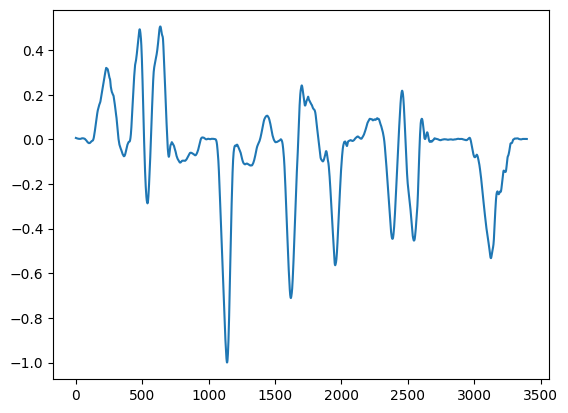

In [7]:
# smooth the data
window_length = 60  # 60 points corresponds to 1 seconds
steer_smooth = scipy.signal.savgol_filter(steer, window_length, 2)
plt.plot(steer_smooth, label="SteeringAngle")
steer = steer_smooth

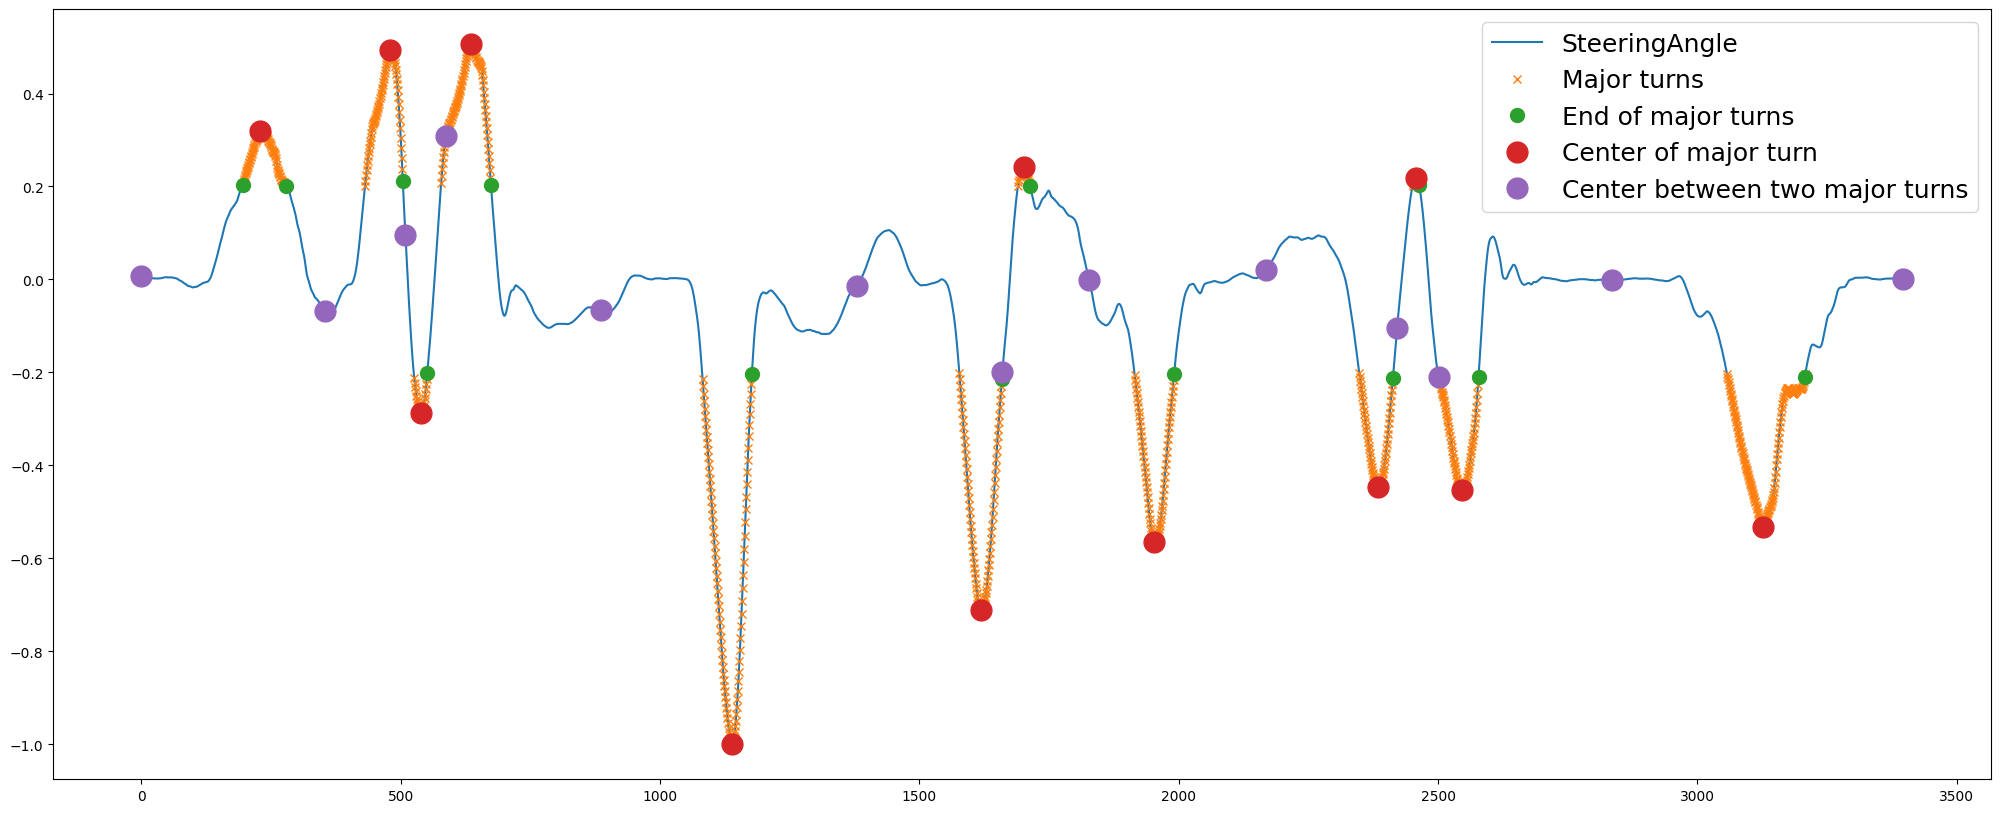

Number of major turns: 12


In [8]:
# Define threshold to select major turns, which means abs(SteeringAngle) > threshold
threshold = 0.2
# Find extrama in SteeringAngle
# Mask 1 gives the indices where SteerinAngle is above thresold : each major turn
msk1 = np.where(np.abs(steer) > threshold)

# Mask 2 gives the indices of the end of a major turn
# which means when the indices giving the major turns are separeted by 10 or more
idx = np.arange(steer.size)[msk1]
idx_diff = idx[1:] - idx[:-1]
msk2 = np.concatenate(([0], np.where(idx_diff > 10)[0], [idx_diff.size - 1]))

# Define the list that will store the extrama indices
extrema_idx = []

# Mask 3 gives the indices of the center of each major turn
for i, m in enumerate(msk2[:-1]):
    # select SteeringAngle for the i turn
    steer_tmp = steer[idx[msk2][i] : idx[msk2][i + 1]]
    # find index of the extrema of SteeringAngle
    extrema_idx_tmp = np.argmax(np.abs(steer_tmp))
    # add idx offset to find the index in the full SteeringAngle array
    extrema_idx_truth = extrema_idx_tmp + idx[msk2][i]
    # add to list
    extrema_idx.append(extrema_idx_truth)

extrema_idx = np.array(extrema_idx)

# Find the begining and end of each segment : center between two major turns
center_idx = ((extrema_idx[1:] + extrema_idx[:-1]) / 2).astype("int32")
center_idx = np.concatenate(([0], center_idx, [steer.size - 1]))

# Plot the Averaged SteeringAngle, and show the identification of major turns
plt.rcParams["figure.figsize"] = (25, 10)
plt.plot(steer, label="SteeringAngle")
plt.plot(idx, steer[msk1], "x", label="Major turns")
plt.plot(idx[msk2], steer[msk1][msk2], "o", label="End of major turns", markersize="10")
plt.plot(
    np.arange(steer.size)[extrema_idx],
    steer[extrema_idx],
    "o",
    label="Center of major turn",
    markersize="15",
)
plt.plot(
    np.arange(steer.size)[center_idx],
    steer[center_idx],
    "o",
    label="Center between two major turns",
    markersize="15",
)
plt.legend(fontsize=18)
plt.show()
print(f"Number of major turns: {len(extrema_idx)}")

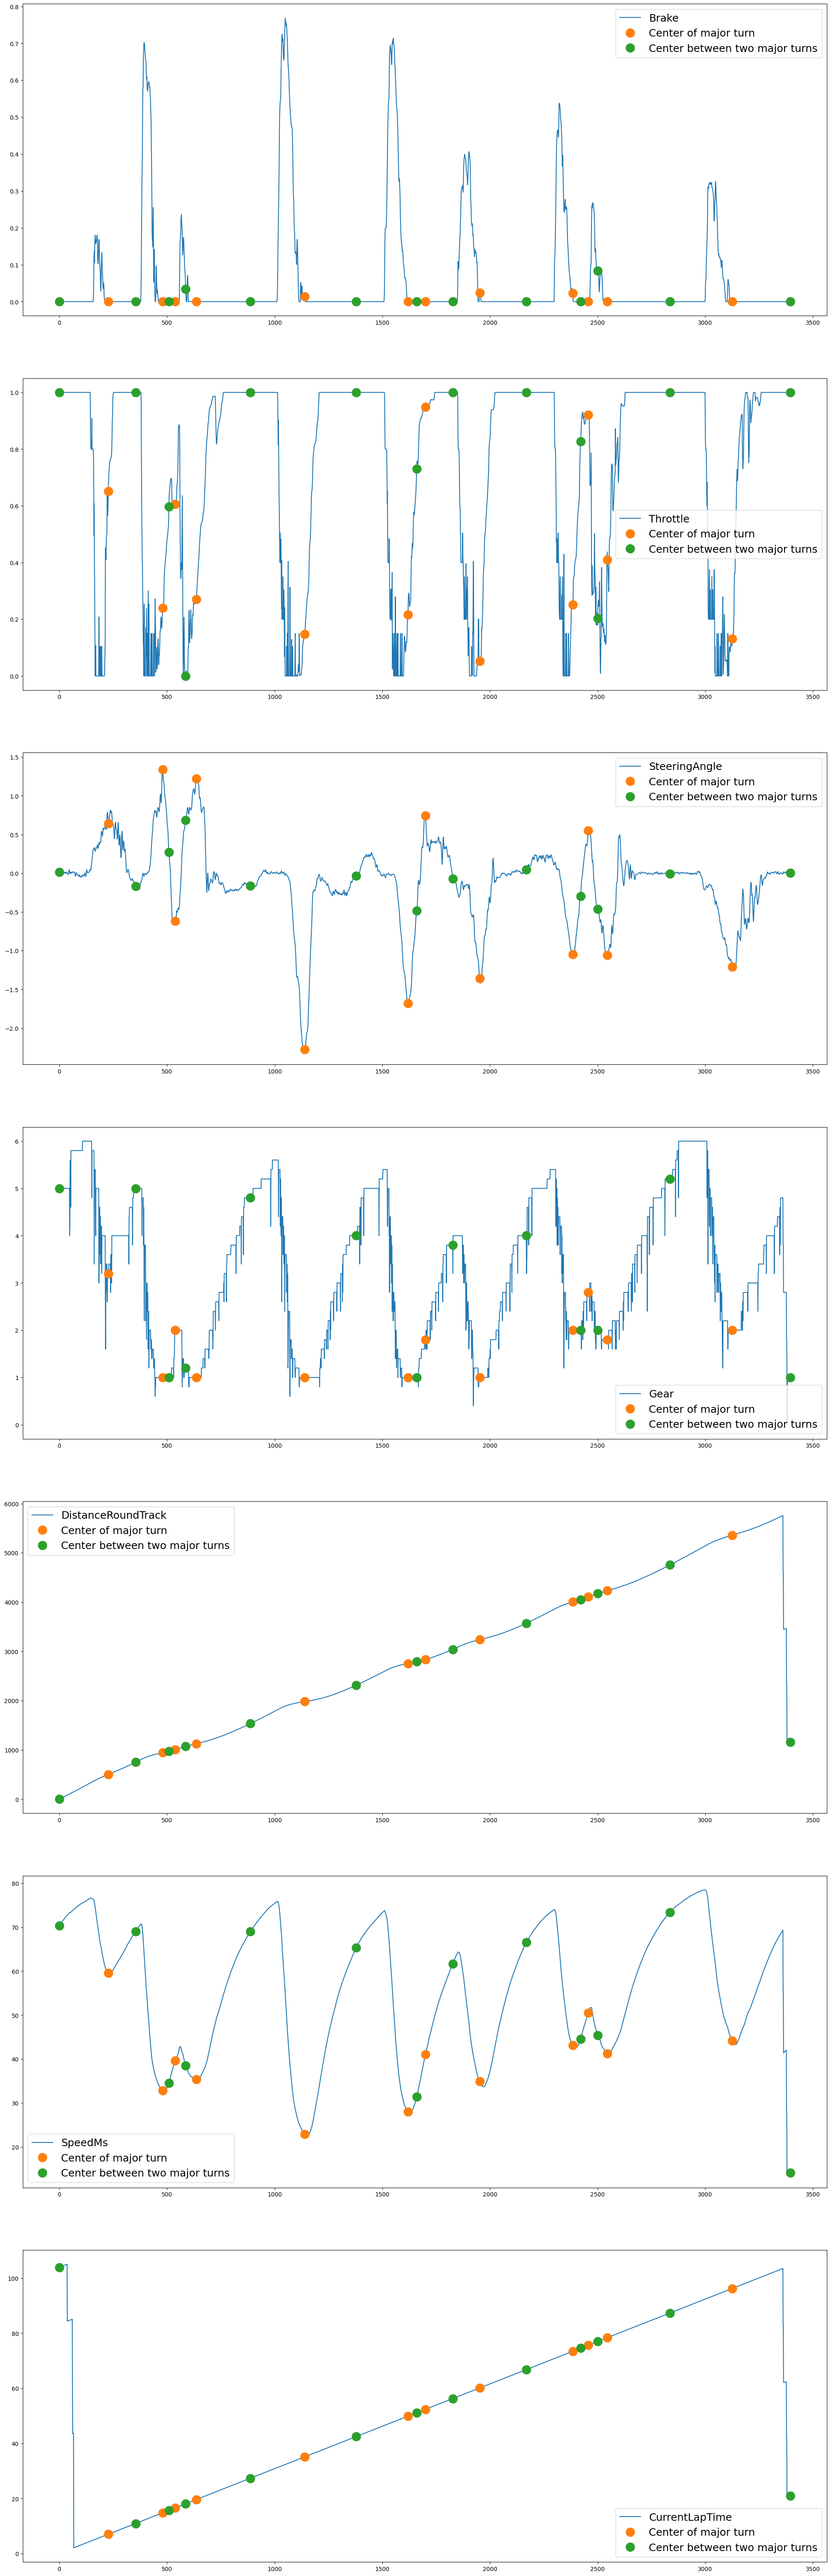

In [9]:
# Plot all data entry and show the center and start/end of each major turn
fig, ax = plt.subplots(len(features), figsize=(25, 80))
for i, feature in enumerate(features):
    data = av_data_arrays[feature]
    # data = scipy.signal.savgol_filter(data, window_length, 2)

    ax[i].plot(data, label=feature)
    # ax[i].plot(idx, av_data_arrays[d][msk1], 'x', label='Major turns')
    # ax[i].plot(idx[msk2], av_data_arrays[d][msk1][msk2], 'o',
    #          label='End of major turns', markersize='10')
    ax[i].plot(
        np.arange(data.size)[extrema_idx],
        data[extrema_idx],
        "o",
        label="Center of major turn",
        markersize="15",
    )
    ax[i].plot(
        np.arange(data.size)[center_idx],
        data[center_idx],
        "o",
        label="Center between two major turns",
        markersize="15",
    )
    ax[i].legend(fontsize=18)
plt.show()

In [10]:
# Build the segment dictionnary that contains a list for each data entry
# these lists gather the data for each turn
track_segment_count = center_idx.size - 1

# initialize dictionnary
segment_data = {}
for feature in features:
    segment_data[feature] = []

# fill the dictionnary
for i in range(track_segment_count):
    for feature in features:
        segment_data[feature].append(
            av_data_arrays[feature][center_idx[i] : center_idx[i + 1]]
        )

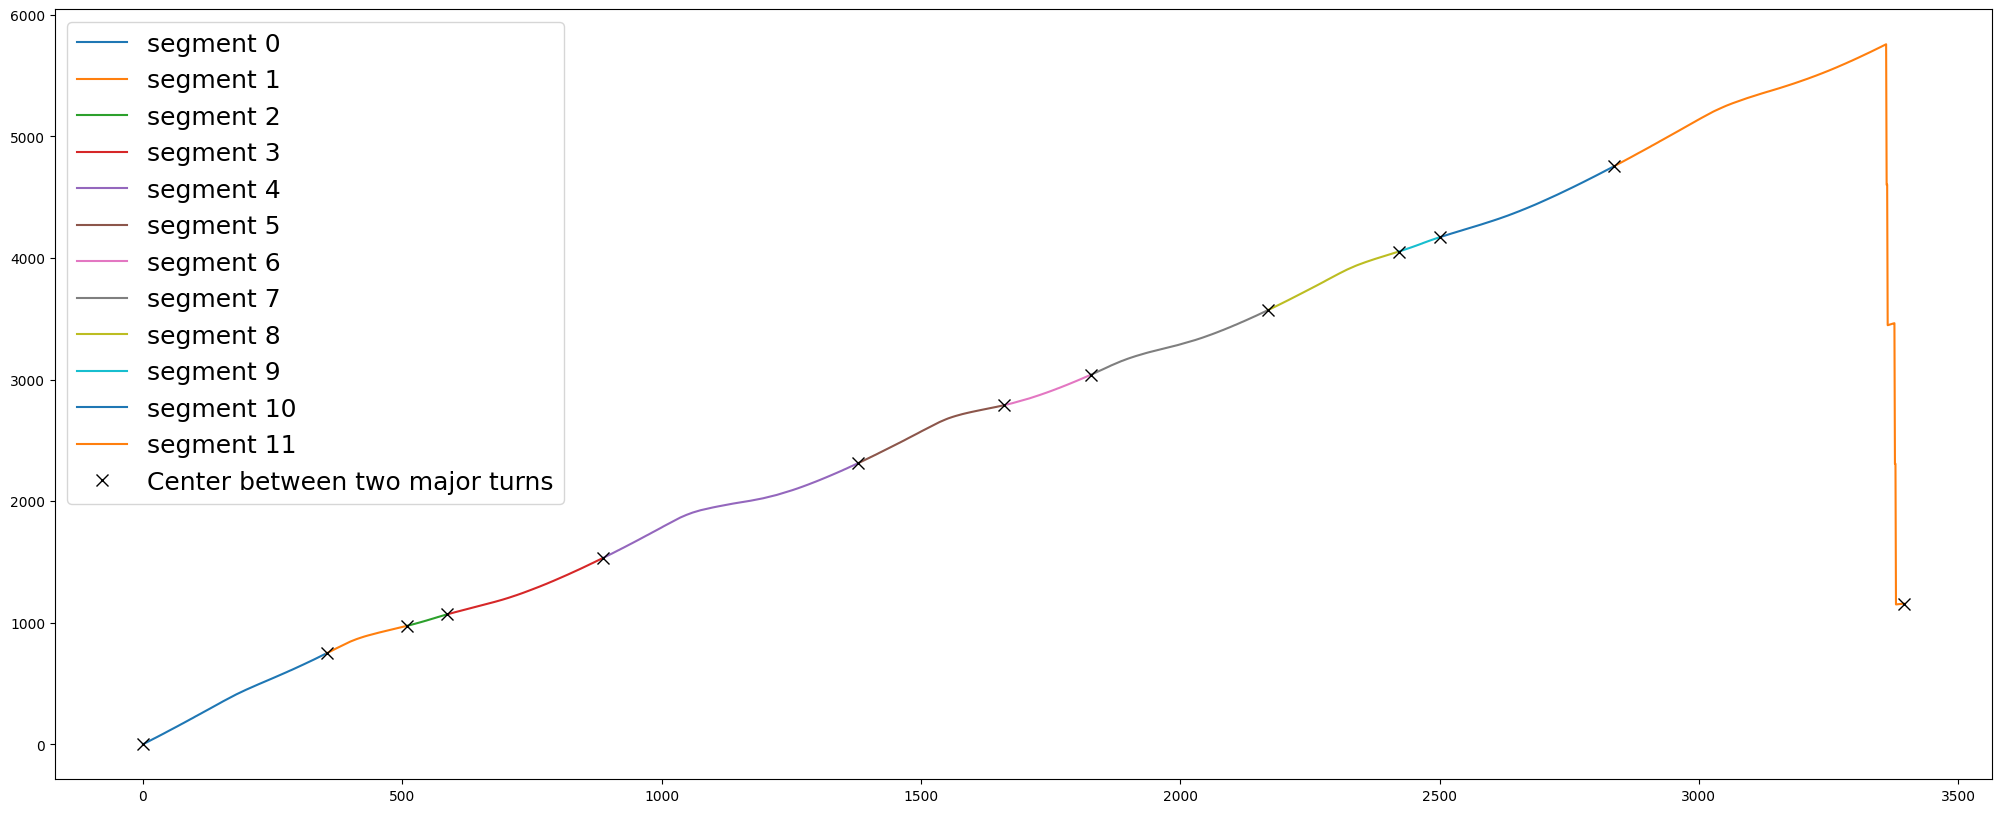

In [11]:
# Plot the segments
plt.rcParams["figure.figsize"] = (25, 10)
for i in range(track_segment_count):
    plt.plot(
        np.arange(steer.size)[center_idx[i] : center_idx[i + 1]],
        segment_data["DistanceRoundTrack"][i],
        label=f"segment {i}",
    )
plt.plot(
    np.arange(steer.size)[center_idx],
    av_data_arrays["DistanceRoundTrack"][center_idx],
    "x",
    label="Center between two major turns",
    markersize="8",
    color="black",
)
plt.legend(fontsize=18)
plt.show()

# Extract track data from fastest laps

From all fastest laps we want to extract the average value for the track guide data.


* start / end: the start and end of the turn (see above)
* brake: the average DistanceRoundTrack when the brake is pressed the first time
* turn_in: the average DistanceRoundTrack when the steering wheel is turned into the corner (maybe use rate of change)
* force: the average value of the maximum brake force during the turn
* gear: the average value of the lowest gear during the turn
* speed: the lowest value during the turn
* stop: the average value when the brake force is starting to decrease
* accelerate: the average DistanceRoundTrack when the throttle is pressed again during the turn


In [12]:
track_info = []
for i in range(track_segment_count):
    track_info.append(
        {
            "start": segment_data["DistanceRoundTrack"][i][0],
            "end": segment_data["DistanceRoundTrack"][i][-1],
        }
    )

In [13]:
# Average DistanceRoundTrack when brake is pressed the first time
for i in range(track_segment_count):
    seg = np.where(segment_data["Brake"][i] > 0)
    if seg[0].size > 0:
        j = seg[0][0]
        track_info[i]["brake"] = segment_data["DistanceRoundTrack"][i][j]

In [14]:
# Average DistanceRoundTrack when brake is released completly
for i in range(track_segment_count):
    seg = np.where(segment_data["Brake"][i] > 0)
    if seg[0].size > 0:
        j = seg[0][-1]
        track_info[i]["turn_in"] = segment_data["DistanceRoundTrack"][i][j]

In [15]:
# Average brake force during the turn
for i in range(track_segment_count):
    track_info[i]["force"] = segment_data["Brake"][i].max()

In [16]:
# Average value of gear at the middle of the turn
for i in range(track_segment_count):
    track_info[i]["gear"] = av_data_arrays["Gear"][extrema_idx][i]

In [17]:
# Average lowest value of speed during the turn
for i in range(track_segment_count):
    track_info[i]["speed"] = av_data_arrays["SpeedMs"][extrema_idx][i]

In [18]:
# Average value of distance when the brake force is at maximum
# FIXME: this is not the right way to do it, we want the distance when the brake force starts to decrease
for i in range(track_segment_count):
    j = np.argmax(segment_data["Brake"][i])
    track_info[i]["stop"] = segment_data["DistanceRoundTrack"][i][j]

In [19]:
# Average DistanceRoundTrack when the throttle is pressed again during the turn
for i in range(track_segment_count):
    seg = np.where(segment_data["Throttle"][i] == segment_data["Throttle"][i].min())
    if seg[0].size > 0:
        j = seg[0][-1]
        track_info[i]["accelerate"] = segment_data["DistanceRoundTrack"][i][j]

In [20]:
# convert track_info, which is an array of dict, to a pandas dataframe
df = pd.DataFrame(track_info)
df.style.format(precision=1)

,start,end,brake,turn_in,force,gear,speed,stop,accelerate
0,0.7,747.1,362.3,472.4,0.2,3.2,59.6,380.1,468.7
1,749.0,973.8,802.8,923.3,0.7,1.0,32.8,833.9,830.2
2,974.6,1068.4,1033.2,1068.4,0.2,2.0,39.6,1044.7,1066.1
3,1069.7,1530.7,1069.7,1083.6,0.1,1.0,35.4,1080.1,1076.7
4,1532.8,2311.1,1810.0,1982.5,0.8,1.0,22.9,1889.1,1956.5
5,2312.6,2788.4,2592.7,2749.5,0.7,1.0,28.0,2678.1,2735.0
6,2789.3,3037.0,nan,nan,0.0,1.8,41.1,2789.3,2789.3
7,3039.0,3569.3,3083.0,3245.8,0.4,1.0,34.9,3177.6,3223.1
8,3571.6,4051.6,3855.5,4007.6,0.5,2.0,43.1,3905.6,3938.9
9,4052.9,4170.3,4116.3,4170.3,0.3,2.8,50.5,4140.1,4170.3


In [21]:
# load handcrafted data
df_handcrafted = pd.read_csv(
    "fast_laps/Ferrari 488 GT3 Evo 2020-sebring international.csv"
)
df_handcrafted.style.format(precision=1)

,turn,start,end,brake,turn_in,force,gear,speed,accelerate,mark
0,1,0,750,325.0,325.0,50.0,4.0,180.0,510.0,nan
1,2-4,750,1000,825.0,875.0,80.0,2.0,100.0,950.0,nan
2,5,1000,1250,1040.0,1040.0,40.0,2.0,110.0,1100.0,nan
3,6,1250,1800,nan,nan,nan,nan,nan,nan,nan
4,7,1800,2100,1825.0,1930.0,80.0,1.0,70.0,1975.0,nan
5,8-9,2100,2400,nan,nan,nan,nan,nan,nan,nan
6,10-11,2400,3000,2640.0,2700.0,90.0,2.0,90.0,2750.0,nan
7,12-13,3000,3350,3130.0,3180.0,80.0,2.0,110.0,3230.0,nan
8,14,3350,3750,nan,nan,nan,nan,nan,nan,nan
9,15,3750,4050,3870.0,3920.0,80.0,3.0,130.0,4000.0,nan


## The actual track
https://iracing.fandom.com/wiki/Sebring_International_Raceway

![image](https://static.wikia.nocookie.net/iracing/images/3/32/Screenshot_2022-12-06_150548.png/revision/latest/scale-to-width-down/441?cb=20221206210704)